# Course work

## Task
Marketing campaigns are an essential part of the business. This is also true for banking services. Meanwhile, the estimation of marketing campaign performance and prediction of performance is a challenging task. Based on historical data related to direct marketing campaigns of a Portuguese banking institution try to predict subscription for deposit

Metrics:
As for subscription prediction, we can't prefer precision or recall and the task is about binary classification, ROC AUC score will be used.
*   ROC AUC score maximization
*   ROC AUC score >= 80%

Dataset for research available [here](https://archive.ics.uci.edu/dataset/222/bank+marketing)

## Product questions
We need to build a prediction model, depending on the usage of this model we could differently use our train data. So we need to understand:
- Will the model be trained and used once before the campaign started to predict results? In this case, we can't train our model with data about the current marketing campaign
- Will the model be used continuously during the marketing campaign for every single user and our prediction about success will change with any new data incoming (like new contact information during the current campaign)? In this case, the whole dataset is applicable. But at what point (monitoring metrics) we should retrain our model as we have more historical data
- Marketing campaigns can have specifics like end and start date, do we have a dataset that covers the whole timeline of the previous campaign?

To find out answers we need to keep in mind the workflow of the user, who will use the model.

I will go with the assumption that the model will be used continuously during one campaign and re-run predictions for specific user on every data update. After the final result (answer yes or no) model metrics will be recalculated and if it is below baseline retrain happen.  

## EDA

In [117]:
import warnings
import pandas as pd
import seaborn as sns
import missingno as msno
import numpy as np
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import RobustScaler

plt = matplotlib.pyplot

warnings.filterwarnings('ignore')

sns.set_theme()

print(f"pandas: {pd.__version__}")
print(f"seaborn: {sns.__version__}")
print(f"missingno: {msno.__version__}")
print(f"numpy: {np.__version__}")

pandas: 1.5.3
seaborn: 0.12.2
missingno: 0.5.2
numpy: 1.22.4


In [67]:
url = 'https://raw.githubusercontent.com/dmytrovelychko/rd_ds_python/main/datasets/bank-additional-full.csv'
df = pd.read_csv(url, sep=";")
print(f"shape: {df.shape}")
df[:100]

shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,45,services,married,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
96,42,management,married,university.degree,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
97,53,admin.,divorced,university.degree,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
98,37,technician,single,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Dataset description
**bank client data:**
   - age (numeric)
   - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   - default: has credit in default? (categorical: "no","yes","unknown")
   - housing: has housing loan? (categorical: "no","yes","unknown")
   - loan: has personal loan? (categorical: "no","yes","unknown")

**related with the last contact of the current campaign:**
   - contact: contact communication type (categorical: "cellular","telephone")
   - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
   - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

**other attributes:**
  - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
  - previous: number of contacts performed before this campaign and for this client (numeric)
  - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
  
  **social and economic context attributes**
  - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  - cons.price.idx: consumer price index - monthly indicator (numeric)     
  - cons.conf.idx: consumer confidence index - monthly indicator (numeric)     
  - euribor3m: euribor 3 month rate - daily indicator (numeric)
  - nr.employed: number of employees - quarterly indicator (numeric)

**  Output variable (desired target):**
  - y - has the client subscribed a term deposit? (binary: "yes","no")

Drop duplicates initially

In [68]:
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(41188, 21)
(41176, 21)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

no empty values set as n/a

Text(0.5, 0, 'y (subscription result)')

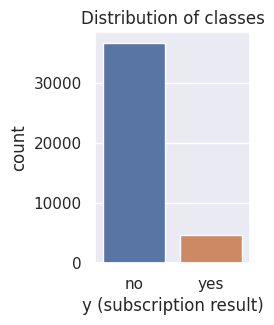

In [5]:
plt.figure(figsize=(2,3))
sns.countplot(x=df['y'])
plt.title('Distribution of classes')
plt.xlabel('y (subscription result)')

Highly imbalanced classes of taget feature

### Numerical features


In [69]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,258.315815,2.567879,962.464810,0.173013,0.081922,93.575720,-40.502863,3.621293,5167.034870
std,10.42068,259.305321,2.770318,186.937102,0.494964,1.570883,0.578839,4.627860,1.734437,72.251364
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


#### age

Text(0.5, 1.0, 'Distribution of users by age')

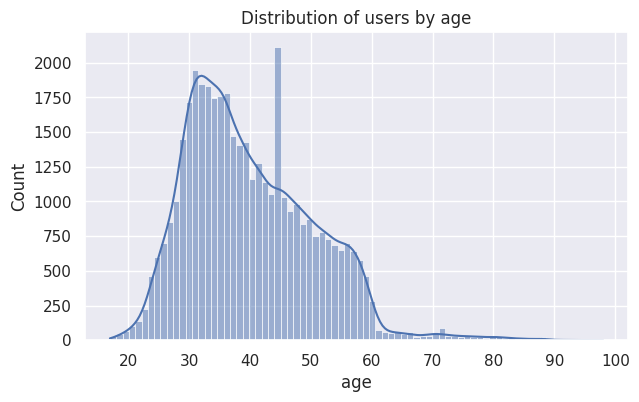

In [92]:
plt.figure(figsize=(7,4))
sns.histplot(df['age'], bins=len(df['age'].unique()), kde=True)
plt.title('Distribution of users by age')

- most if the users 25<age<60

Text(0.5, 0, 'age')

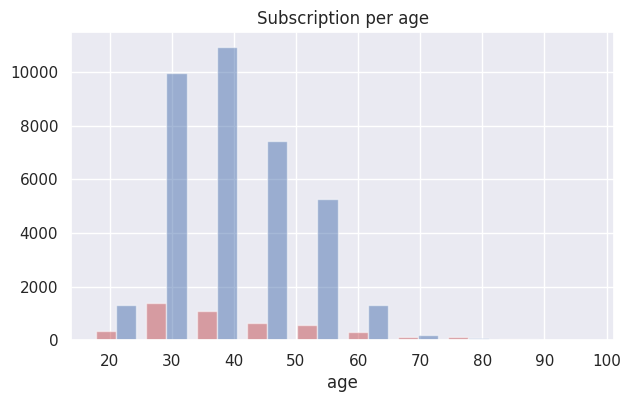

In [94]:
plt.figure(figsize=(7,4))
plt.hist([df[df['y'] == 'yes']['age'], df[df['y'] == 'no']['age']], color=['r','b'], alpha=0.5)
plt.title('Subscription per age')
plt.xlabel('age')

- highest subscription count for near age = 30
- more younger more tend to subscribe for age >= 25

Text(0.5, 1.0, 'Outliers for age')

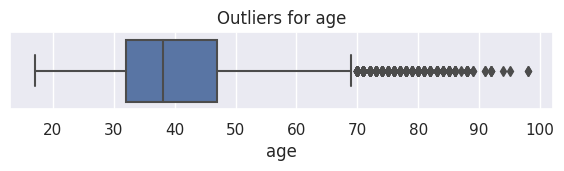

In [100]:
plt.figure(figsize=(7,1))
sns.boxplot(data=df, x="age")
plt.title('Outliers for age')

Text(0, 0.5, 'subscription')

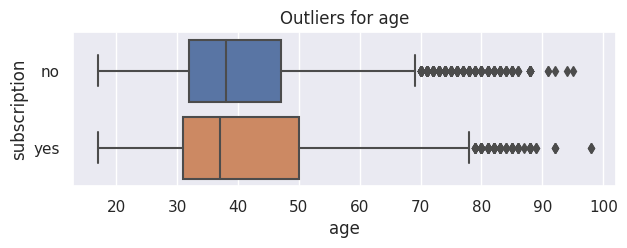

In [101]:
plt.figure(figsize=(7,2))
sns.boxplot(data=df, x="age", y="y")
plt.title('Outliers for age')
plt.ylabel('subscription')

- outliers candidates are with age>=70

In [79]:
print(df[df['age'] >= 70].shape)
df[df['age'] >= 70].sort_values('age').tail()

(469, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
40469,92,retired,married,unknown,no,no,yes,cellular,aug,wed,...,1,3,4,success,-1.7,94.027,-38.3,0.903,4991.6,yes
38921,94,retired,married,basic.9y,no,no,no,cellular,nov,wed,...,1,999,1,failure,-3.4,92.649,-30.1,0.716,5017.5,no
27826,95,retired,divorced,basic.6y,no,no,no,cellular,mar,thu,...,1,999,0,nonexistent,-1.8,92.843,-50.0,1.650,5099.1,no
38455,98,retired,married,basic.4y,unknown,yes,no,cellular,oct,fri,...,2,999,0,nonexistent,-3.4,92.431,-26.9,0.730,5017.5,yes
38452,98,retired,married,basic.4y,unknown,yes,no,cellular,oct,fri,...,1,2,2,success,-3.4,92.431,-26.9,0.730,5017.5,yes


- outliers by age doesn't provide any unsual patterns, small amount can be dropped if needed by later checks

#### duration

In [70]:
df['duration'] = df["duration"] / 60 # convert seconds to min

Text(0.5, 1.0, 'Distribution of users by duration')

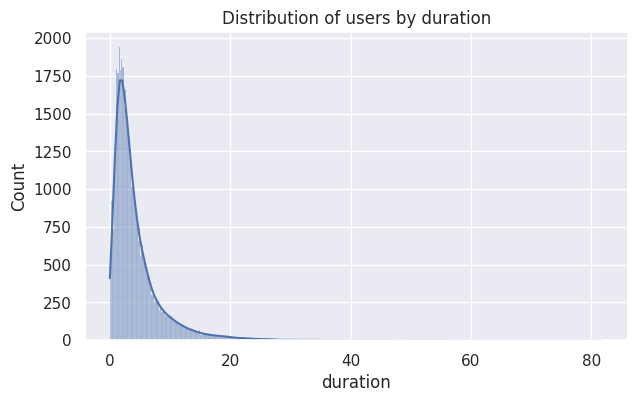

In [102]:
plt.figure(figsize=(7,4))
sns.histplot(df['duration'], kde=True)
plt.title('Distribution of users by duration')

In [54]:
df_duration_lt_20 = df[df['duration'] < 20]

Text(0.5, 0, 'duration')

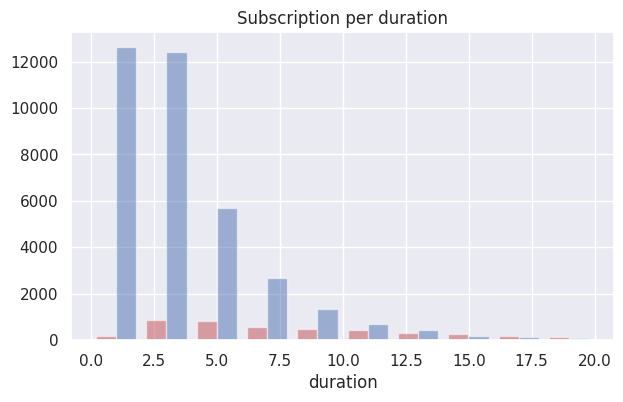

In [103]:
plt.figure(figsize=(7,4))
plt.hist([df_duration_lt_20[df_duration_lt_20['y'] == 'yes']['duration'], df_duration_lt_20[df_duration_lt_20['y'] == 'no']['duration']], color=['r','b'], alpha=0.5)
plt.title('Subscription per duration')
plt.xlabel('duration')

Data about call duration is just for notes, we will note use it in prediction model as this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model. In short we can't provide this data to our model before we started the call

In [71]:
df = df.drop(columns=['duration'])

#### campaign

Text(0.5, 1.0, 'Distribution by number of contacts during campaign')

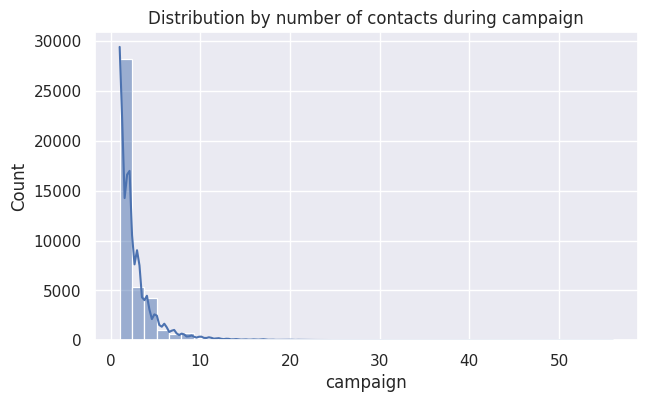

In [104]:
plt.figure(figsize=(7,4))
sns.histplot(df['campaign'], bins=40, kde=True)
plt.title('Distribution by number of contacts during campaign')

Text(0.5, 1.0, 'Distribution by number of contacts during campaign')

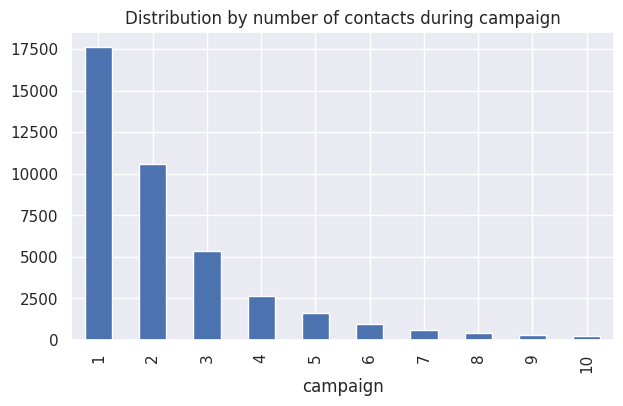

In [105]:
plt.figure(figsize=(7,4))
df[df['campaign'] <= 10].groupby('campaign').count()['y'].plot.bar()
plt.title('Distribution by number of contacts during campaign')

Text(0.5, 0, 'campaign')

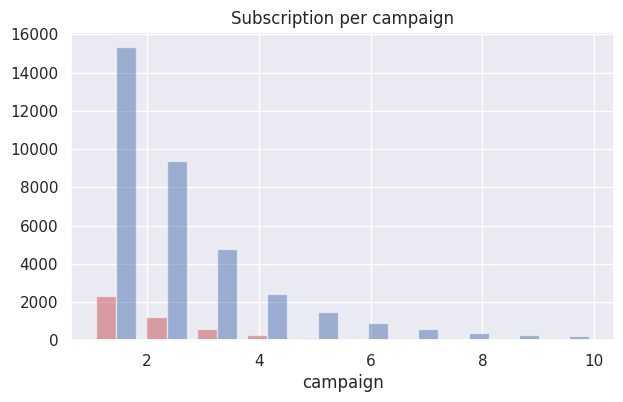

In [106]:
plt.figure(figsize=(7,4))
df_campain_lte_10 = df[df['campaign'] <= 10]
plt.hist([df_campain_lte_10[df_campain_lte_10['y'] == 'yes']['campaign'], df_campain_lte_10[df_campain_lte_10['y'] == 'no']['campaign']], color=['r','b'], alpha=0.5)
plt.title('Subscription per campaign')
plt.xlabel('campaign')

- current campagin historical data has mosly <=3 contacts during campaign
- less contacts per user more subscriptions
- a lot of contacts with the same user don't provide higher subscription rate

Text(0.5, 1.0, 'Outliers for campaign')

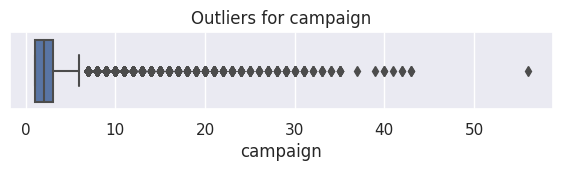

In [107]:
plt.figure(figsize=(7,1))
sns.boxplot(data=df, x="campaign")
plt.title('Outliers for campaign')

Text(0, 0.5, 'subscription')

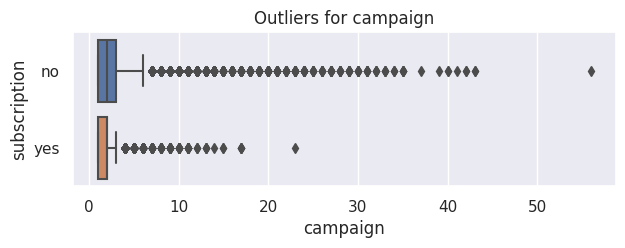

In [108]:
plt.figure(figsize=(7,2))
sns.boxplot(data=df, x="campaign", y="y")
plt.title('Outliers for campaign')
plt.ylabel('subscription')

let's check tail of outliers by campaign

In [88]:
df[df['campaign'] > 35][['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']]

,age,job,marital,education,default,housing,loan,contact,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
4107,32,admin.,married,university.degree,unknown,unknown,unknown,telephone,56,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
4114,52,entrepreneur,married,university.degree,no,no,no,telephone,39,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
4168,29,technician,married,professional.course,no,yes,no,telephone,42,999,0,nonexistent,1.1,93.994,-36.4,4.858,5191.0,no
5304,44,retired,married,basic.9y,no,yes,no,telephone,42,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
11033,38,blue-collar,married,basic.4y,no,yes,no,telephone,41,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
11593,43,technician,married,high.school,no,yes,no,telephone,37,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
11769,56,self-employed,married,professional.course,no,no,yes,telephone,40,999,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no
13447,32,technician,single,university.degree,no,yes,yes,telephone,43,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18728,54,admin.,married,university.degree,unknown,yes,no,cellular,43,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18754,36,admin.,single,university.degree,no,no,no,cellular,40,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no


After several iteration can say:
- respondens have simialar social and economic attributes
- all not subscribed
- doesn't look as invalid or wrong data

#### pdays

Text(0.5, 1.0, 'Distribution by pdays')

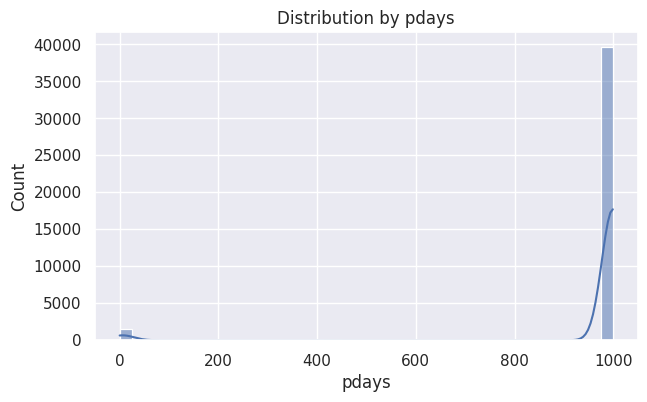

In [109]:
plt.figure(figsize=(7,4))
sns.histplot(df['pdays'], bins=40, kde=True)
plt.title('Distribution by pdays')

pdays=999 means no contacts, let's filter out this data

Text(0.5, 1.0, 'Distribution by pdays')

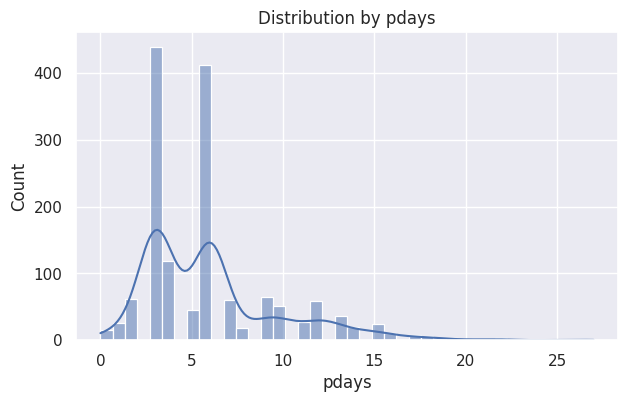

In [110]:
df_pdays_neq_999 = df[df['pdays'] < 999]
plt.figure(figsize=(7,4))
sns.histplot(df_pdays_neq_999['pdays'], bins=40, kde=True)
plt.title('Distribution by pdays')

In [112]:
count_pdays_neq_999 = df_pdays_neq_999.shape[0]
count_pdays_eq_999 = df[df['pdays'] == 999].shape[0]
print(f"Not contacted in previous campaign: {count_pdays_eq_999}, {count_pdays_eq_999/df.shape[0]*100}")

Not contacted in previous campaign: 39673, 96.32174419733903


Text(0, 0.5, 'subscription')

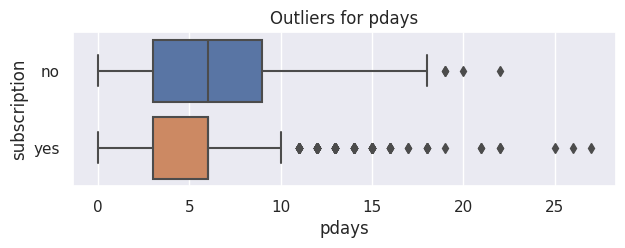

In [114]:
plt.figure(figsize=(7,2))
sns.boxplot(data=df_pdays_neq_999, x="pdays", y="y")
plt.title('Outliers for pdays')
plt.ylabel('subscription')

- most of the client was not contacted in our dataset = 96.3%
- if client was contacted, that happened mostly not more than 17 days ago
- no strict patterns for days passed from last contact and subscriptions

#### previous

Text(0.5, 1.0, 'Distribution by number of contacts before campaign')

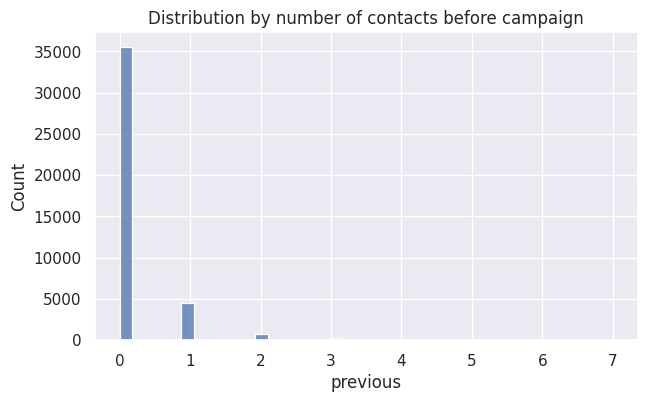

In [47]:
plt.figure(figsize=(7,4))
sns.histplot(df['previous'], bins=40)
plt.title('Distribution by number of contacts before campaign')

In [122]:
print(f"Total records with at least one contacts from previous campaign: {df[df['previous'] > 0].shape}")
print(f"Percantage: {df[df['previous'] > 0].shape[0]/df.shape[0]*100}")

Total records with at least one contacts from previous campaign: (5625, 21)
Percantage: 13.65689035641449


- we don't have much data about previous campaign only 13.5% was contacted at least once
- 13.5% still to much to just drop it, but it is possible to ignore inputs from previous campaign for better model preforming. Possible columns to drop: [pdays, previous, poutcome]

In [125]:
df_conacted_at_least_once = df[df['previous'] + df['campaign'] > 0]
print(f"Number of clients we have contacted at least once in dataset: {df_conacted_at_least_once.shape[0]}")
print(f"Percantage: {df_conacted_at_least_once.shape[0]/df.shape[0]*100}")

Number of clients we have contacted at least once in dataset: 41188
Percantage: 100.0


In [126]:
df["campaign"].min()

1

- we have contacted all clients during current campaign in dataset

#### emp.var.rate

Text(0.5, 1.0, 'Distribution by emp.var.rate')

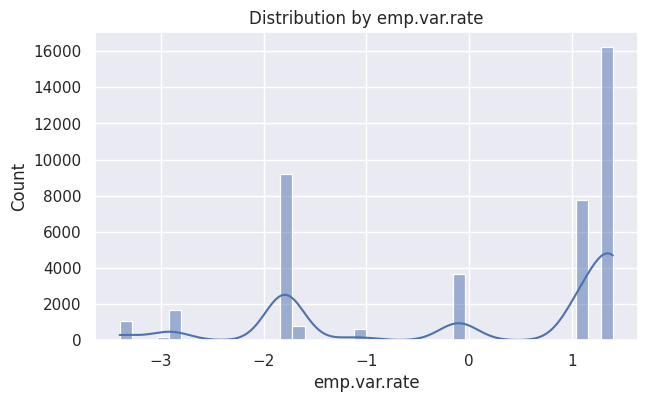

In [128]:
plt.figure(figsize=(7,4))
sns.histplot(df['emp.var.rate'], bins=40, kde=True)
plt.title('Distribution by emp.var.rate')

Text(0, 0.5, 'subscription')

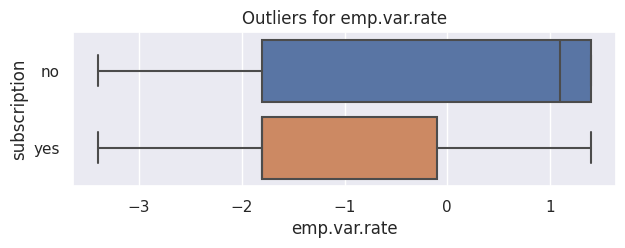

In [129]:
plt.figure(figsize=(7,2))
sns.boxplot(data=df, x="emp.var.rate", y="y")
plt.title('Outliers for emp.var.rate')
plt.ylabel('subscription')

#### cons.price.idx

Text(0.5, 1.0, 'Distribution by cons.price.idx')

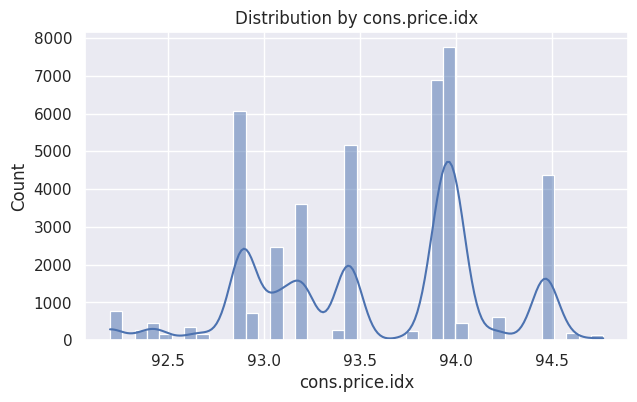

In [130]:
plt.figure(figsize=(7,4))
sns.histplot(df['cons.price.idx'], bins=40, kde=True)
plt.title('Distribution by cons.price.idx')

Text(0, 0.5, 'subscription')

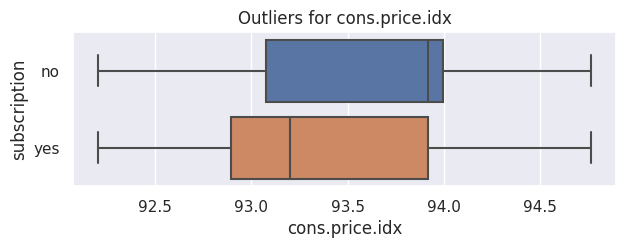

In [131]:
plt.figure(figsize=(7,2))
sns.boxplot(data=df, x="cons.price.idx", y="y")
plt.title('Outliers for cons.price.idx')
plt.ylabel('subscription')

#### cons.conf.idx

Text(0.5, 1.0, 'Distribution by cons.conf.idx')

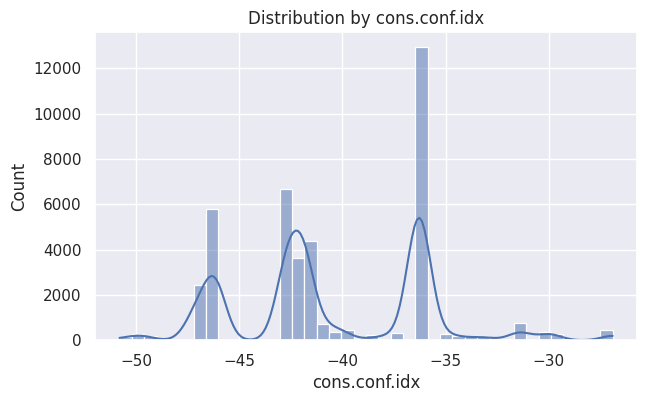

In [135]:
plt.figure(figsize=(7,4))
sns.histplot(df['cons.conf.idx'], bins=40, kde=True)
plt.title('Distribution by cons.conf.idx')

Text(0, 0.5, 'subscription')

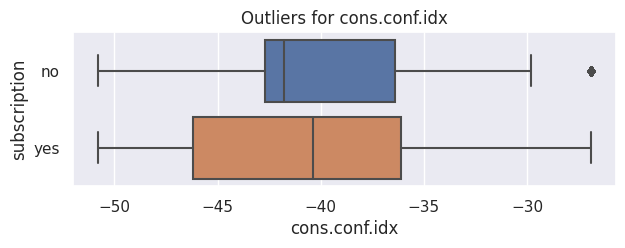

In [133]:
plt.figure(figsize=(7,2))
sns.boxplot(data=df, x="cons.conf.idx", y="y")
plt.title('Outliers for cons.conf.idx')
plt.ylabel('subscription')

Text(0.5, 1.0, 'Outliers for cons.conf.idx')

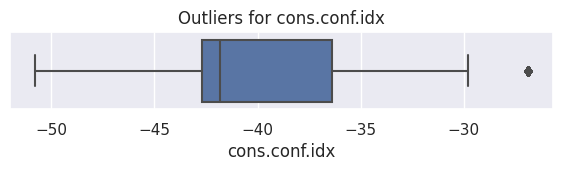

In [139]:
plt.figure(figsize=(7,1))
sns.boxplot(data=df, x='cons.conf.idx')
plt.title('Outliers for cons.conf.idx')

In [152]:
df_conf_idx_outliers = df[df['cons.conf.idx'] == -26.9]
print(df_conf_idx_outliers.shape)
df_conf_idx_outliers.head()

(446, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
38154,50,management,married,university.degree,no,yes,no,cellular,oct,thu,...,2,4,1,success,-3.4,92.431,-26.9,0.754,5017.5,yes
38155,37,admin.,single,university.degree,no,yes,no,cellular,oct,thu,...,3,999,0,nonexistent,-3.4,92.431,-26.9,0.754,5017.5,yes
38156,59,technician,single,basic.6y,no,no,no,cellular,oct,thu,...,1,999,2,failure,-3.4,92.431,-26.9,0.754,5017.5,no
38157,31,admin.,married,university.degree,no,yes,no,cellular,oct,thu,...,1,999,0,nonexistent,-3.4,92.431,-26.9,0.754,5017.5,no
38158,35,admin.,married,high.school,no,yes,no,cellular,oct,thu,...,1,4,1,success,-3.4,92.431,-26.9,0.754,5017.5,yes


In [153]:
df_conf_idx_outliers.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,446.00000,446.000000,446.000000,446.000000,446.000000,4.460000e+02,4.460000e+02,4.460000e+02,446.000000,446.0
mean,45.61435,4.669432,1.522422,831.869955,0.504484,-3.400000e+00,9.243100e+01,-2.690000e+01,0.735482,5017.5
std,17.11768,4.500906,0.836359,372.133691,0.718130,8.891758e-16,2.845363e-14,3.556703e-15,0.008819,0.0
min,17.00000,0.816667,1.000000,2.000000,0.000000,-3.400000e+00,9.243100e+01,-2.690000e+01,0.720000,5017.5
25%,32.00000,2.037500,1.000000,999.000000,0.000000,-3.400000e+00,9.243100e+01,-2.690000e+01,0.728000,5017.5
50%,40.00000,3.150000,1.000000,999.000000,0.000000,-3.400000e+00,9.243100e+01,-2.690000e+01,0.739000,5017.5
75%,59.00000,5.462500,2.000000,999.000000,1.000000,-3.400000e+00,9.243100e+01,-2.690000e+01,0.741000,5017.5
max,98.00000,36.450000,6.000000,999.000000,3.000000,-3.400000e+00,9.243100e+01,-2.690000e+01,0.754000,5017.5


In [158]:
df_conf_idx_outliers.groupby("y").count()["age"]

y
no     266
yes    180
Name: age, dtype: int64

After several iterations and checks, can say:
- outliers have very similar social and economic context attributes
- include 3:2 subcribed and not subscribed clients
- clients don't have credit by default, mostly no loan and not much housing loans


#### euribor3m

Text(0.5, 1.0, 'Distribution by euribor3m')

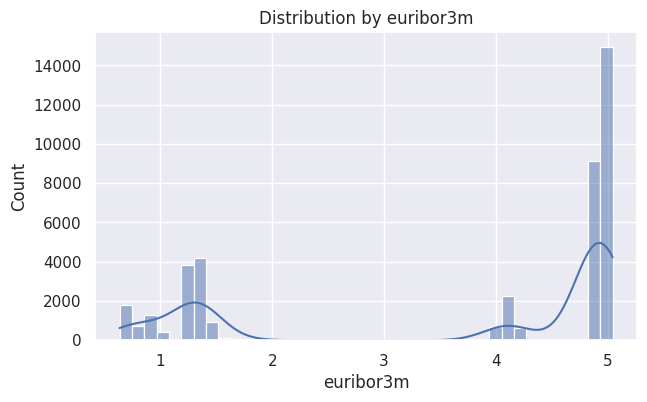

In [166]:
plt.figure(figsize=(7,4))
sns.histplot(df['euribor3m'], bins=40, kde=True)
plt.title('Distribution by euribor3m')

Text(0, 0.5, 'subscription')

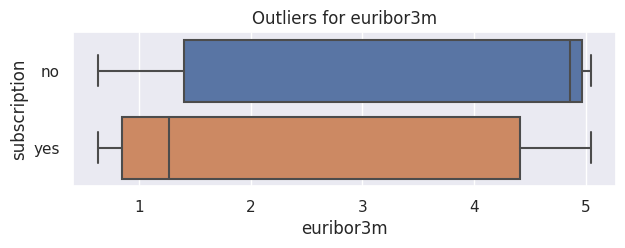

In [167]:
plt.figure(figsize=(7,2))
sns.boxplot(data=df, x="euribor3m", y="y")
plt.title('Outliers for euribor3m')
plt.ylabel('subscription')

- no outliers
- we have 2 groups of high and low euribors, means clients with higher and lower interest rates for mortages

#### nr.employed

Text(0.5, 1.0, 'Distribution by nr.employed')

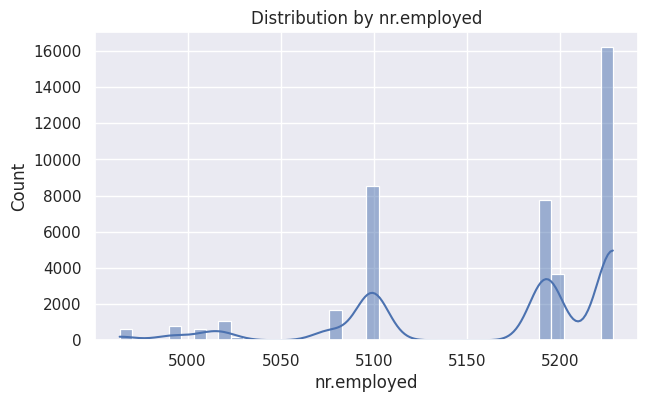

In [168]:
plt.figure(figsize=(7,4))
sns.histplot(df['nr.employed'], bins=40, kde=True)
plt.title('Distribution by nr.employed')

Text(0, 0.5, 'subscription')

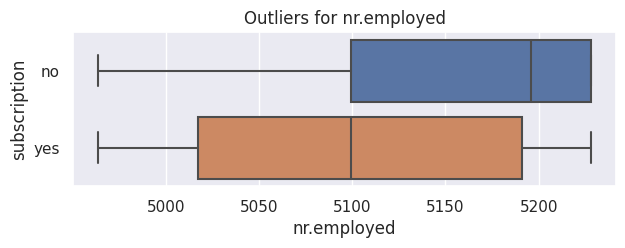

In [42]:
plt.figure(figsize=(7,2))
sns.boxplot(data=df, x="nr.employed", y="y")
plt.title('Outliers for nr.employed')
plt.ylabel('subscription')

- no outliers
- users with high nr.employed tend to not subscribe more than with low and average

### Correlations

To check correlation with categorical feature "y" need to do encoding first

In [72]:
subscription_map = {'no': 0, 'yes': 1}
df['y'] = df['y'].map(subscription_map)

<Axes: >

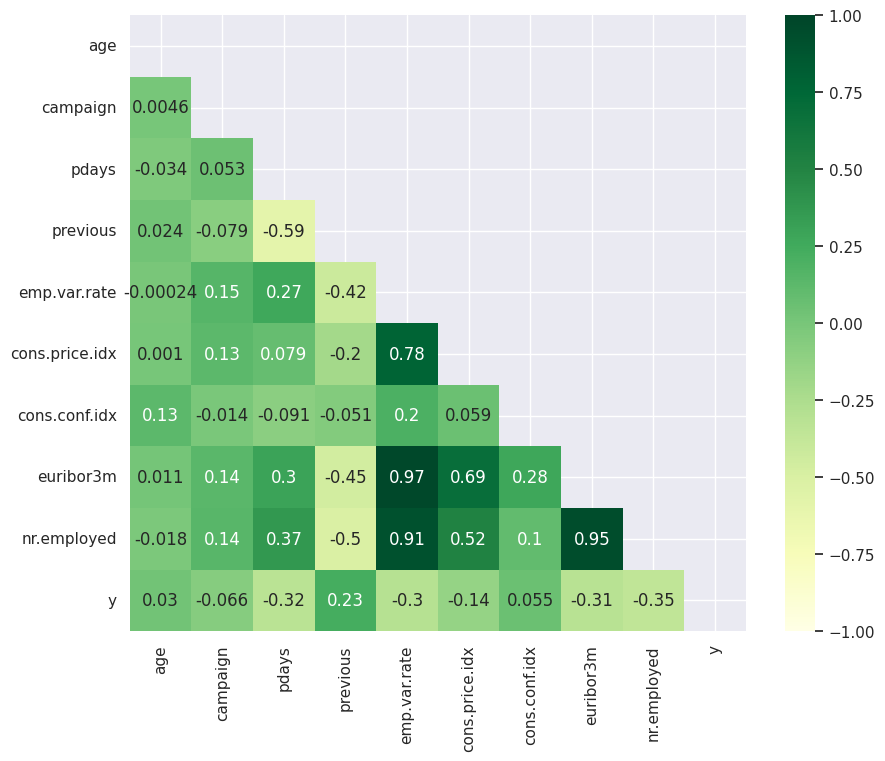

In [25]:
fig = plt.figure(figsize=(10,8))

corr = df.dropna().corr()
mask = np.triu(df.corr())

sns.heatmap(corr, annot=True, mask=mask, vmin=-1, vmax=1, square=True, cmap='YlGn')

Let's check pariplots for features witout 'emp.var.rate', 'nr.employed', 'cons.price.idx' that are highly correlated with euribor3m

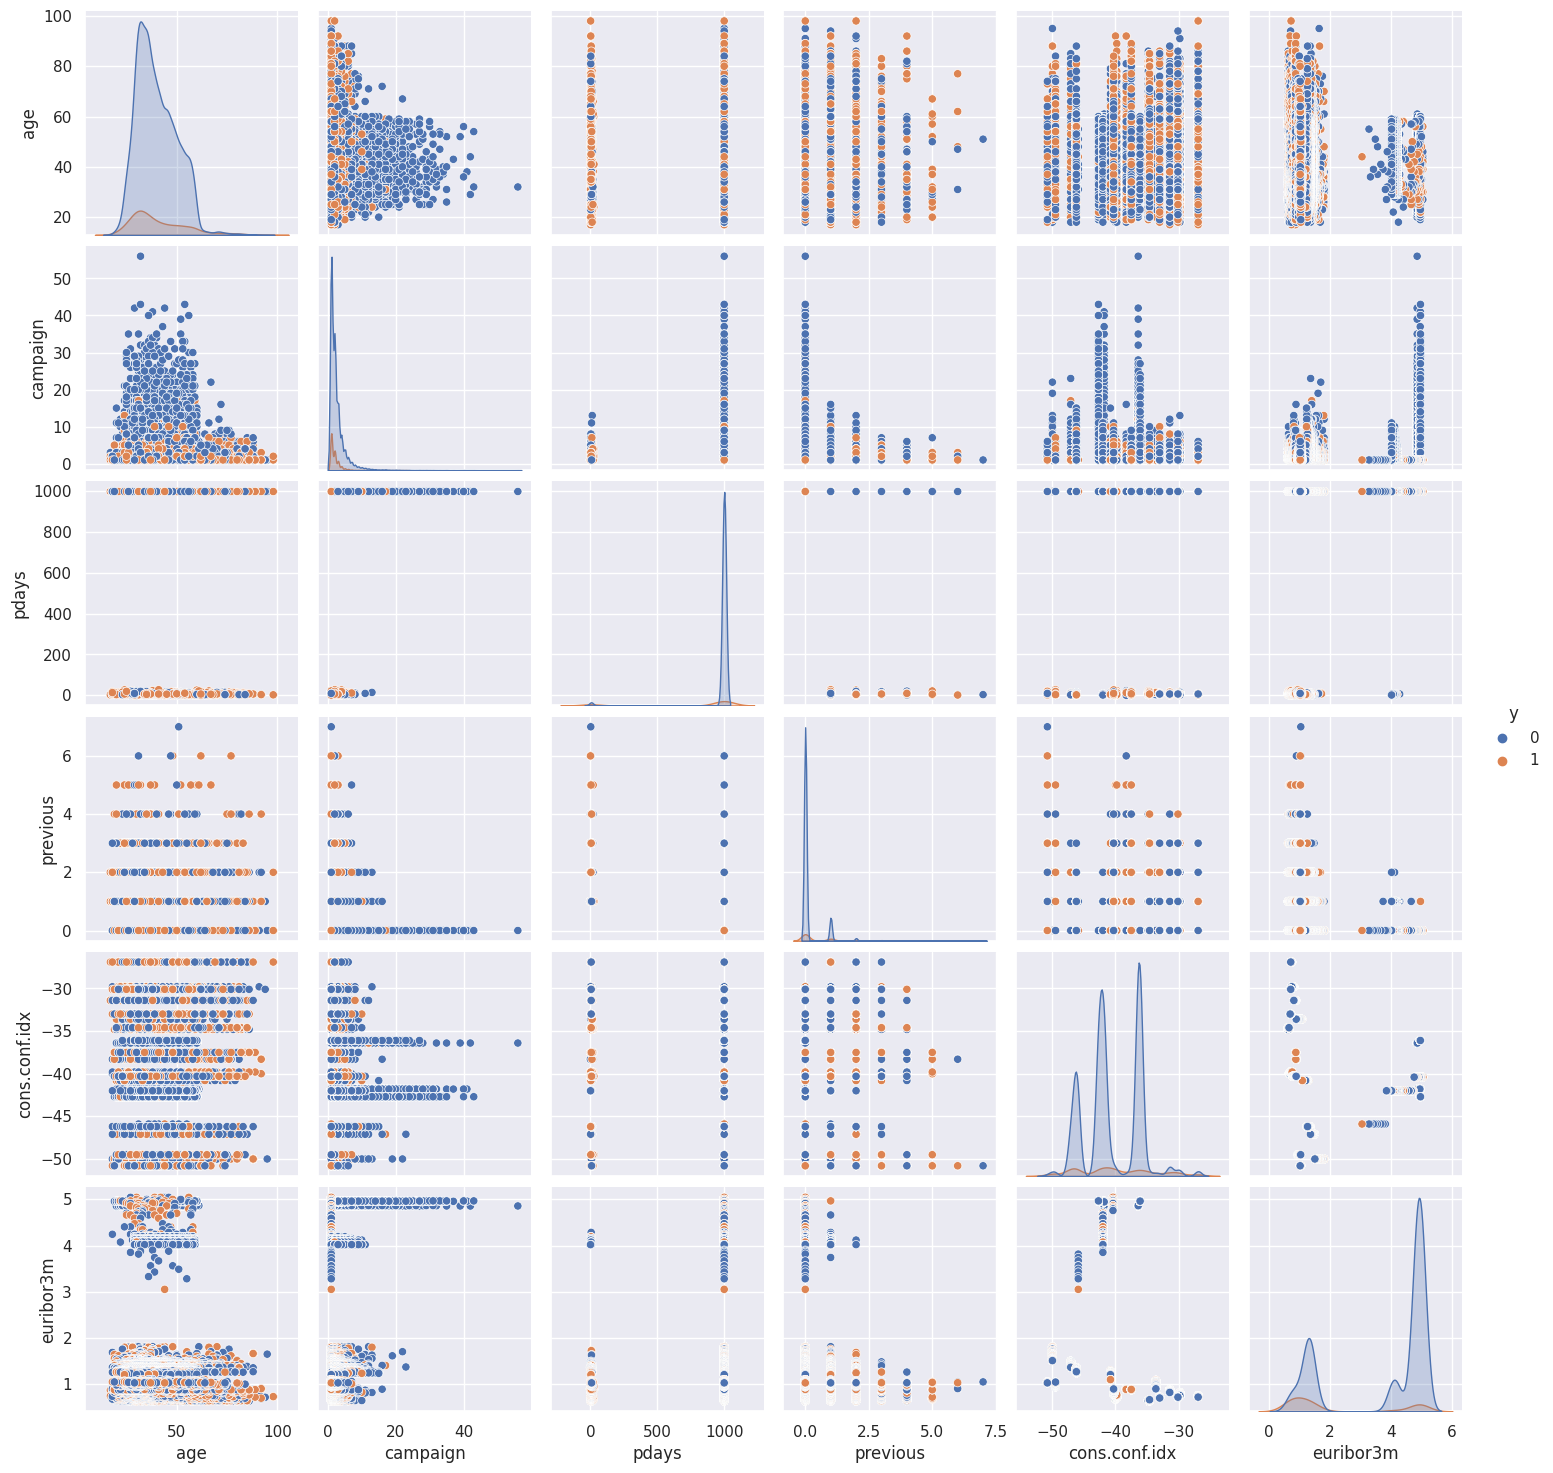

In [32]:
sns.pairplot(df[['age', 'campaign', 'pdays', 'previous', 'cons.conf.idx', 'euribor3m', 'y']], hue='y')

- age-campaign the only feature pair that has significant plot difference, other overlap a lot

### Numerical feature summary

  - subsciption has weak correlation with single numerical features. The highest 0.35 for nr.employed feature
  - we have high correlation between features like: ['euribor3m', 'emp.var.rate', 'nr.employed']
  - age has very weak correlation with any other numerical feature
  - previous has significant correlation with other feautres, but we don't have much data about previous campaign only 13.5% was contacted at least once
  - ['age', 'campaign', 'pdays', 'cons.conf.idx'] has outliers, as subscription has poor correlation with single numerical features, better to use scaling robust to outliers or drop them
  - pair plots have a lot of overlapping which tends to complexity in classification for target feature


### Categorical features

In [74]:
cat_cols = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "day_of_week", "poutcome"]

In [75]:
for col in cat_cols:
  print(df[col].value_counts(), '\n')

admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64 

married     24921
single      11564
divorced     4611
unknown        80
Name: marital, dtype: int64 

university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: education, dtype: int64 

no         32577
unknown     8596
yes            3
Name: default, dtype: int64 

yes        21571
no         18615
unknown      990
Name: housing, dtype: int64 

no         33938
yes         6248
unknown      990
Name: loan, dtype: int64 

cellular     26135
telephone    15041
Name: contact, dtype: int64 

may    13767
jul     716

- features with unknown: ["job", "marital", "education", "default", "housing", "loan", "contact", "nonexistent"]
- it is completly possible to have unknown values in input data to our model, better to keep them as a separate category value, let's see how models can perform without amputation


In [10]:
def plot_hist_feature_compare_by_subscriptions(feature, figsize=(7,4), rotation=0):
  plt.figure(figsize=figsize)
  plt.hist([df[df['y'] == 1][feature], df[df['y'] == 0][feature]], color=['r','b'], alpha=0.5)
  plt.title(f"Subscription per {feature}")
  plt.xticks(rotation=rotation)
  plt.xlabel(feature)

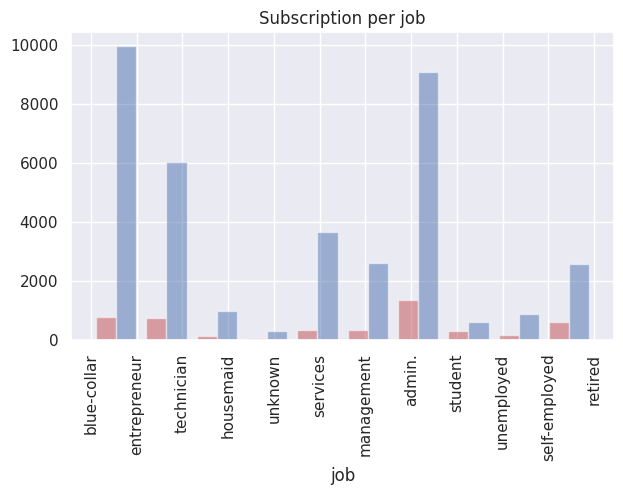

In [35]:
plot_hist_feature_compare_by_subscriptions('job', rotation=90)

- most of the respondents are blue-collar or admin
- 330 job unknown


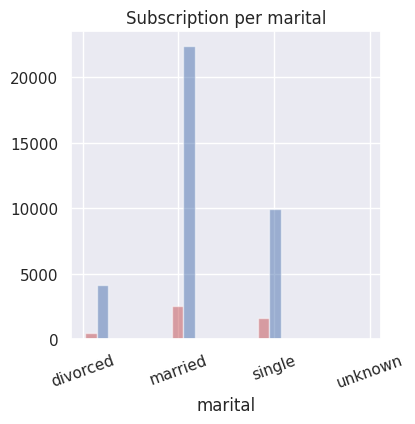

In [31]:
plot_hist_feature_compare_by_subscriptions('marital', (4,4), 20)

- most are married
- unknown 80

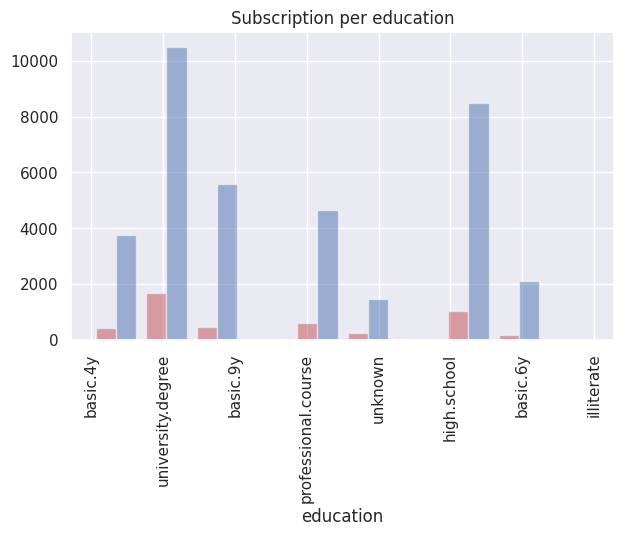

In [38]:
plot_hist_feature_compare_by_subscriptions('education', rotation=90)

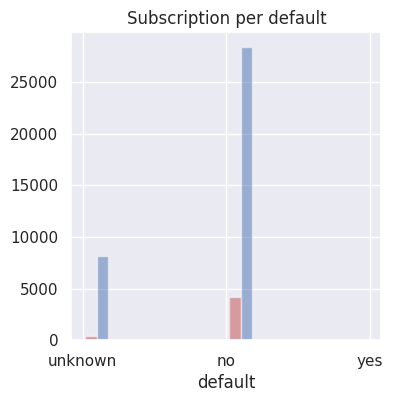

In [11]:
plot_hist_feature_compare_by_subscriptions('default', (4,4))

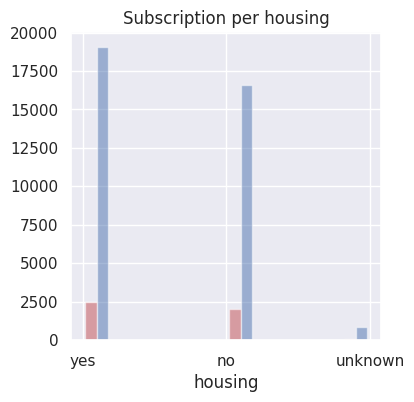

In [12]:
plot_hist_feature_compare_by_subscriptions('housing', (4,4))

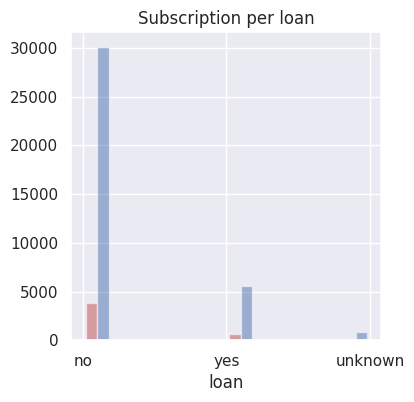

In [13]:
plot_hist_feature_compare_by_subscriptions('loan', (4,4))

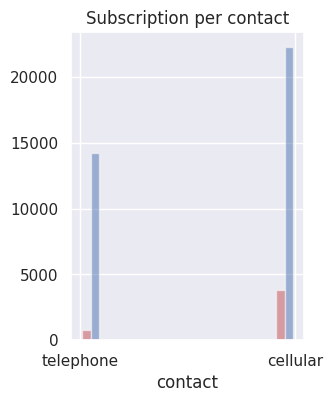

In [27]:
plot_hist_feature_compare_by_subscriptions('contact', (3,4))

- contact is a contact communication type. What does it means in real world? does it represent what type of telephone client have? or only type that was provided by client to the bank? or communication type client has responded to the bank from available contacts? how type of telephone provided by the client can characterize client in sense of credit subscription?
- without answers for such questions we have a risk to include untransparent parameter which can have a high bias in our dataset. For now will leave this feature out of scope even if it has association with target feature
- subscription success is a result of proper marketing, timing and state of the need of the client. Our model should be focused on the state of the client to predict result, timing is out of scope for such feature list

In [76]:
df = df.drop(columns=['contact'])

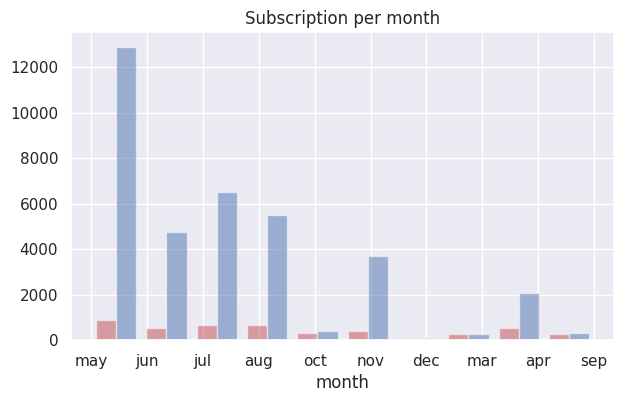

In [43]:
plot_hist_feature_compare_by_subscriptions('month')

This data has complex relation to the target feature, month - last contact month of year, means client can be contacted multiply times and in different month of the year, we need to now a duration of campaign we have train our model and duration of campaign we want to run prediction which is not avaiable, possibility of intersection of campaigns in our dataset for training and in the future. Seasonal and time dependency of campaign should be a separate research with more data.

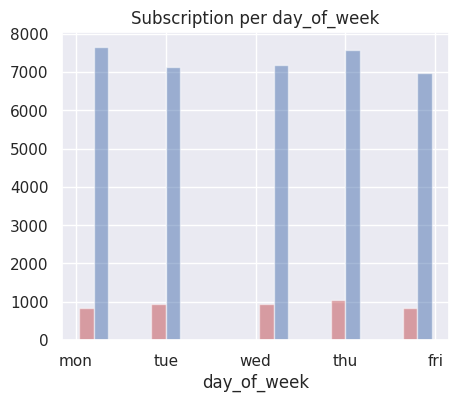

In [57]:
plot_hist_feature_compare_by_subscriptions('day_of_week', (5,4))

- day of week when last contact happpen shows near equal distribution and do not bring much value to subscription prediction, hence will not use it in model

In [77]:
df = df.drop(columns=['day_of_week'])

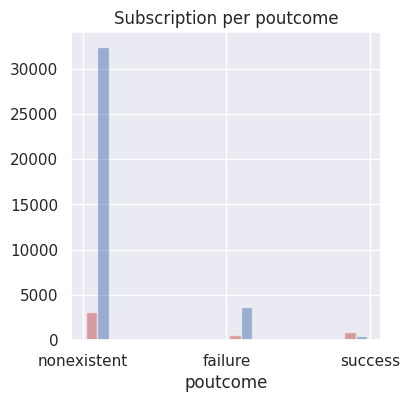

In [58]:
plot_hist_feature_compare_by_subscriptions('poutcome', (4,4))

Summary:
 - in absolute scale, client with most subscriptions looks like: admin, married, university.degree, does not have credit in default, has housing loan, no personal loan, can be contacted by cellular. For not subscribed in absolut scale it looks like: entrepreneur, married, university degree, no credit by default, housing loan, no personal loan, contacted by cellular
 - most of the poutcome is nonexistent, we have small amount of data about previous campaign. It is reasonable to decide:
  - (1) we can drop all data about previous campaign to make prediction based only on current
  - (2) we can train model only on data with previous campaign to strict model input to have data about previous and current campaign
  - (3) we can include all data for model training
  Answer for the question highly depends on business context, how and when we should make prediction? what is the intersection of clients set between previous and current campagin? should our model perform for the next one campaign or several?
  For now will go with option 3, as we make prediction on every data update for every client, we can have different states of dataset and need to be ready to handle inputs with only previous campaign data (which now is not in dataset, we can make simulate this on some portion of data); with previous and current campaign data; only with current campaign data.


## Data preprocessing

onehot encoding:
* job          
* marital    
* default      
* housing     
* loan        
* poutcome     

ordinal encoding:
* education  
* month    

normalization:
* age
* campaign
* cons.conf.idx
* cons.price.idx
* emp.var.rate
* euribor3m
* nr.employed
* pdays
* previous




In [78]:
y = df["y"]
x = df.drop(columns="y")

In [79]:
x.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'month', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

In [80]:
ordinal_cols = ['education', 'month']
nominal_cols = ['job', 'marital', 'default', 'housing', 'loan', 'poutcome']
numerical_cols = np.setdiff1d(np.setdiff1d(x.columns, nominal_cols), ordinal_cols)
numerical_cols

array(['age', 'campaign', 'cons.conf.idx', 'cons.price.idx',
       'emp.var.rate', 'euribor3m', 'nr.employed', 'pdays', 'previous'],
      dtype=object)

In [81]:
x['education'].unique()

array(['basic.4y', 'high.school', 'basic.6y', 'basic.9y',
       'professional.course', 'unknown', 'university.degree',
       'illiterate'], dtype=object)

education feature is ordinal but has uknown value, to make an ordered sequence of values we can:
- drop them and make a requirement for model input to set education
- predict education based on other parameters
- substitute with median or modal
Will go with last option for simplicity, better to substitude with median instead of modal as our modal has max rank = 'university.degree'

In [82]:
education = x['education'].copy()
education = education[education != 'unknown']
education.value_counts()

university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
illiterate                18
Name: education, dtype: int64

In [83]:
education = education.map({'illiterate':0, 'basic.4y':1, 'basic.6y':2, 'basic.9y':3, 'high.school':4, 'professional.course':5, 'university.degree':6})

In [84]:
education.median()

4.0

In [86]:
x['education'] = x['education'].replace('unknown', 'high.school')

In [87]:
x['education'].value_counts()

university.degree      12164
high.school            11242
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
illiterate                18
Name: education, dtype: int64

In [89]:
x['month'].unique()

array(['may', 'jun', 'jul', 'aug', 'oct', 'nov', 'dec', 'mar', 'apr',
       'sep'], dtype=object)

there are only 10 values in dataset, but our model should expect all 12 possible month

In [91]:
categories = [
  ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree'],
  ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
]

ordinalEncoder = OrdinalEncoder(categories=categories)
ordinalEncoder.fit(x[['education', 'month']])
x[['education', 'month']] = ordinalEncoder.transform(x[['education', 'month']])

In [93]:
ordinalEncoder.categories_

[array(['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school',
        'professional.course', 'university.degree'], dtype=object),
 array(['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep',
        'oct', 'nov', 'dec'], dtype=object)]

In [ ]:
## TODO should I do encoding only one train set??

### Onehot

In [ ]:
## TODO what about multicolinear problem of features
# job     12 (unknown)
# marital  4 (unknown)
# default  3 (unknown)
# housing  3 (unknown)
# loan     3 (unknown)
# poutcome 3 (nonexistent)

In [101]:
len(x.columns)

17

There is a risk to have to many dependencies between features after using onehot encoding, but let's see if we reach target metric with including unknown and all features

In [112]:
x_encoded = pd.get_dummies(x, columns=nominal_cols)
x_encoded.head()

,age,education,month,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,1.0,4.0,1,999,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,1,0,0,0,1,0
1,57,4.0,4.0,1,999,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,1,0,0,0,1,0
2,37,4.0,4.0,1,999,0,1.1,93.994,-36.4,4.857,...,0,0,0,1,1,0,0,0,1,0
3,40,2.0,4.0,1,999,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,1,0,0,0,1,0
4,56,4.0,4.0,1,999,0,1.1,93.994,-36.4,4.857,...,0,1,0,0,0,0,1,0,1,0


### Numeric

In [138]:
x_train_full, x_test, y_train_full, y_test = train_test_split(x_encoded, y, stratify=y, test_size=0.2)
print('Test shape {} {}'.format(x_test.shape, y_test.shape))

Test shape (8236, 39) (8236,)


In [139]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, stratify=y_train_full, test_size=0.2)

In [140]:
print('Validation shape {} {}'.format(x_val.shape, y_val.shape))
print('Train shape {} {}'.format(x_train.shape, y_train.shape))

Validation shape (6588, 39) (6588,)
Train shape (26352, 39) (26352,)


In [118]:
robustScaler = RobustScaler()
robustScaler.fit(x_train[numerical_cols])
x_num_scaled = robustScaler.transform(x_train[numerical_cols])
x_num_scaled_df = pd.DataFrame(x_num_scaled, columns=numerical_cols)
x_num_scaled_df[:5]

,age,campaign,cons.conf.idx,cons.price.idx,emp.var.rate,euribor3m,nr.employed,pdays,previous
0,1.266667,0.5,0.000000,0.779108,0.09375,0.001935,0.287597,0.0,0.0
1,-0.533333,-0.5,0.158730,-0.855277,-1.25000,-0.992812,-0.889922,0.0,0.0
2,0.066667,1.5,-0.698413,-0.931447,-0.90625,-0.988665,-0.712403,0.0,0.0
3,-0.600000,-0.5,-0.031746,-0.597388,-0.37500,-0.231131,0.037209,0.0,0.0
4,-0.933333,-0.5,0.285714,0.138194,-0.90625,-1.157036,-1.413178,0.0,3.0


In [130]:
x_num_scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26352 entries, 0 to 26351
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             26352 non-null  float64
 1   campaign        26352 non-null  float64
 2   cons.conf.idx   26352 non-null  float64
 3   cons.price.idx  26352 non-null  float64
 4   emp.var.rate    26352 non-null  float64
 5   euribor3m       26352 non-null  float64
 6   nr.employed     26352 non-null  float64
 7   pdays           26352 non-null  float64
 8   previous        26352 non-null  float64
dtypes: float64(9)
memory usage: 1.8 MB


In [133]:
x_num_scaled_df.isna().sum().sum()

0

In [135]:
x_num_scaled_df.shape

(26352, 9)

In [134]:
x_train.isna().sum().sum()

0

In [131]:
x_train.shape

(26352, 39)

In [141]:
x_train_scaled = x_train.copy()
for col in numerical_cols:
  x_train_scaled[col] = x_num_scaled_df[col]

In [142]:
x_train_scaled.head()

,age,education,month,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,...,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,poutcome_failure,poutcome_nonexistent,poutcome_success
9188,0.133333,6.0,5.0,-0.5,0.0,1.0,-0.90625,-0.733406,-0.841270,-0.954382,...,0,1,0,0,1,0,0,0,1,0
12944,0.600000,5.0,6.0,0.5,0.0,0.0,0.09375,-0.331882,0.904762,0.029859,...,0,0,0,1,1,0,0,0,1,0
13710,-0.333333,4.0,6.0,1.0,0.0,0.0,0.09375,-0.331882,0.904762,0.029583,...,0,1,0,0,1,0,0,0,1,0
32476,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,1,0,0,0,0,1,1,0,0
18615,-0.666667,3.0,6.0,-0.5,0.0,0.0,-0.90625,-0.413493,1.111111,-1.165054,...,0,0,1,0,0,1,0,0,1,0


In [38]:
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
degree = 2
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('poly_features', PolynomialFeatures(degree=degree)),
    ('model', Lasso())
])
np.arange(0,10,0.1).shape
(100,)
search = GridSearchCV(
    pipeline,
    {'model__alpha':np.arange(0,10,0.1)},
    cv = 5,
    scoring="neg_mean_squared_error",
    verbose=3
)
search.fit(X.loc[train_id], y.loc[train_id])
# random search is better

In [20]:
# TODO candidates algorithm for model (forest etc)
Logistic regression
Decision tree
Random forest
Support vector machine
K nearest neighbours
Naive Bayes

Ansamble of models?
# TODO hyperparameter optimization
# TODO Cross validation strategy?
# TODO Confusion matrix

SyntaxError: ignored

порахувати тренувальні, валідаційні і тестові метрики

In [9]:
# validatoin metrics to choose hyper parameters etc or choose better model
# test metrics to calc actual performance

зробити висновки з коротким описом, чому обрали саме ту чи іншу модель,
метрики, проаналізувати, як вдалося покращити результати протягом валідації

Conclusion:
- subscription results of marketing can possibly have seasonal bias which is poorly represented in current dataset, it needs to be enriched with more features
- seasonabilty and timeline of contacts with clients during current and previous campaign should be done as a separate research and possibly be used for building separate models to be used in ansambles for subscription prediction as can have significant impact
- usage and proportion of records with previous and current campaign data needs to be taken in account during designing of prediction model